# PyTCR - Example 4: Generate tropical cyclone rainfall over a specific region


**Author:** [Phong Le](https://github.com/levuvietphong)

**Description:** This notebook shows how to generate rainfall driven by tropical cyclones for a specific region of interest using shapefiles.

### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import colorcet as cc

import tcr.rainfall as tcr_rain
import tcr.wind as tcr_wind
import tcr.iodata as tcr_io
import tcr.plots as tcr_plot

### Configuration and Data

In [2]:
# Shapefile of Beaumont region in Southeast Texas
shapefile = '../data/shapefiles/setx_bound.shp'
shp_region = shpreader.Reader(shapefile)

# Plotting period
yearmin = 1964
yearmax = 2014
num_years = yearmax - yearmin + 1

# Directory containing the downscaled data
data_directory = '../data/downscaled/'

### Load data from a CMIP6 model
In this notebook, the [E3SM version 1.0](https://e3sm.org/) is demonstrated but the notebook is applicable to other [CMIP6 models](https://pcmdi.llnl.gov/CMIP6/).
- The downscaling model does not provide the radius of maximum circular wind.
- We will estimate it using the wind speed only once and save it to the dataset.
- If the radius is already in the dataset, we will load it without computation.

In [3]:
model = 'E3SM-1-0'
expmnt='historical'

# Load NetCDF data
ds, lat_trks, lon_trks, n_trk, v_trks, vmax_trks, u850_trks, v850_trks, \
    tc_month, tc_years, tc_time = tcr_io.load_netcdf_track_data(
    data_directory=data_directory, model=model, basin='NA', expmnt=expmnt)

# check if radius of maximum wind is available, if not estimate it.
rm_trks = tcr_wind.estimate_radius_wind(
    ds, lat_trks, vmax_trks, n_trk, data_directory=data_directory, model=model,
    basin='NA', expmnt=expmnt, force_recompute=False
)

# Calculate translation speeds (knots) of the storms.
ut, vt, jmax = tcr_wind.utrans(lat_trks, lon_trks)

The radius of maximum circular wind was found in file!
Loading rm_trks...


### Estimate total rainfall over the shapefile domain

In [4]:
delta = 0.01  # Spatial resolution of gridded rainfall data output
storm_ids = 527

# No secondary eyewall included
x, y, netrain = tcr_rain.rainswathx(
    storm_ids, lat_trks, lon_trks, rm_trks, v_trks, 
    0 * rm_trks, 0 * v_trks, ut, vt, u850_trks, v850_trks, 
    dellatlongs=delta, shapefile=shapefile
)

### Visualization of Event Total Rainfall over the domain loaded from a shapefile

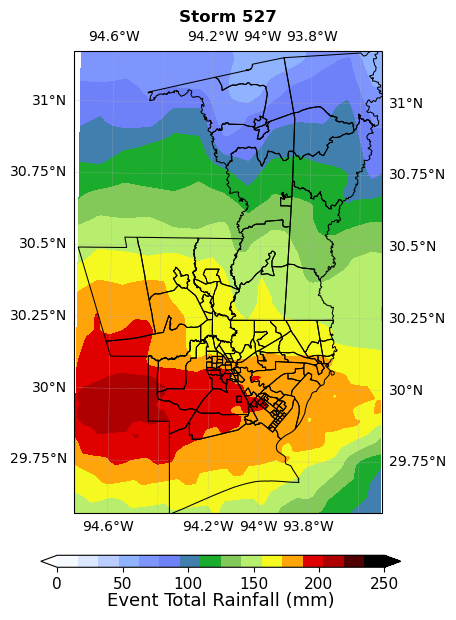

In [17]:
projection = ccrs.UTM(zone=15)  # Projection for Southeast Texas
cmap = tcr_plot.load_cpt_colormap('../data/colormaps/precip2_17lev.cpt')
max_precip = 250
levels = np.linspace(0, max_precip, 17)
extent = [np.min(x), np.max(x), np.min(y), np.max(y)]

# Plot Event Total Rainfall (ETR)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), facecolor="w", subplot_kw=dict(projection=projection))
im = tcr_plot.plot_density(
    ax, y, x, netrain, levels, extent=extent, projection=projection, cmap=cmap,
    gridlabel=True, gridspace=1, shapefile=shp_region, coastlines=False,
    add_features=False, method='contourf'
)
ax.set_title(f'Storm {storm_ids}', fontweight='bold')

# Add colorbar
cbax = fig.add_axes([0.2, 0.02, 0.6, 0.02])
cb = fig.colorbar(im, cax=cbax, orientation='horizontal')
cb.set_label(r'Event Total Rainfall (mm)', fontsize=13, labelpad=0)
cb.set_ticks(np.linspace(0, max_precip, 6))
cb.ax.tick_params(labelsize=11)